In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import tensorflow as tf
import shutil

In [2]:
data_dir = '/content/drive/MyDrive/XAUUSD_Candlestick_5_M_BID_01.01.2022-06.08.2022.csv'
df = pd .read_csv(data_dir)

print(df.shape)
df.tail()

(62772, 6)


,Local time,Open,High,Low,Close,Volume
62767,06.08.2022 23:35:00.000 GMT+0430,1774.718,1774.718,1774.718,1774.718,0.0
62768,06.08.2022 23:40:00.000 GMT+0430,1774.718,1774.718,1774.718,1774.718,0.0
62769,06.08.2022 23:45:00.000 GMT+0430,1774.718,1774.718,1774.718,1774.718,0.0
62770,06.08.2022 23:50:00.000 GMT+0430,1774.718,1774.718,1774.718,1774.718,0.0
62771,06.08.2022 23:55:00.000 GMT+0430,1774.718,1774.718,1774.718,1774.718,0.0


In [3]:
new_df = df[df['Volume'] != 0]
print(new_df.shape)
new_df.head()

(42354, 6)


,Local time,Open,High,Low,Close,Volume
0,01.01.2022 00:00:00.000 GMT+0330,1828.478,1828.624,1828.434,1828.514,40399.9994
1,01.01.2022 00:05:00.000 GMT+0330,1828.514,1829.054,1828.468,1828.984,58690.0013
2,01.01.2022 00:10:00.000 GMT+0330,1828.984,1829.128,1828.718,1828.964,29900.0003
3,01.01.2022 00:15:00.000 GMT+0330,1828.964,1829.608,1828.934,1829.528,53070.0003
4,01.01.2022 00:20:00.000 GMT+0330,1829.554,1830.248,1829.454,1829.898,75590.0014


In [17]:
inp_arr = np.array(new_df['Close'])

print('Shape:', np.shape(inp_arr))

Shape: (42354,)


In [18]:
def windowed_dataset(series, window_size, prediction_window, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + prediction_window, shift = 1, drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + prediction_window))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-prediction_window], window[-prediction_window:]))
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [19]:
split_time = int(0.8*len(inp_arr))
print('split time is:',split_time)

x_train = inp_arr[:split_time] 
x_valid = inp_arr[split_time:] 

print('shape of x_train',np.shape(x_train))
print('shape of x_valid',np.shape(x_valid))

window_size = 100
prediction_window = 1
batch_size = 32
shuffle_buffer = 50000

split time is: 33883
shape of x_train (33883,)
shape of x_valid (8471,)


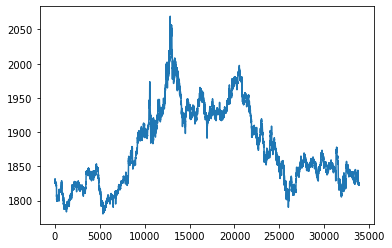

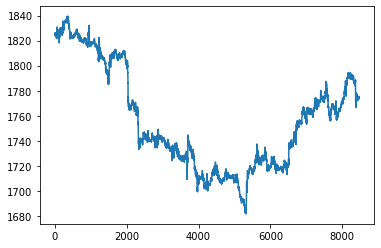

In [20]:
plt.plot(x_train)
plt.figure()
plt.plot(x_valid)
plt.show()

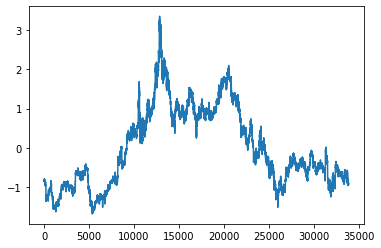

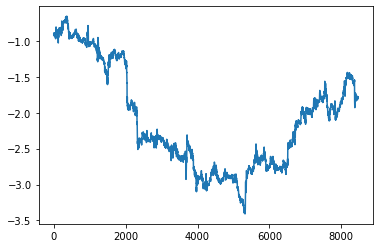

In [21]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
x_train_std = std_scaler.fit_transform(np.expand_dims(x_train, axis=-1))
x_valid_std = std_scaler.transform(np.expand_dims(x_valid, axis=-1))

plt.plot(x_train_std)
plt.figure()
plt.plot(x_valid_std)

In [22]:
dataset = windowed_dataset(x_train_std, window_size = window_size, prediction_window = prediction_window
                           , batch_size = batch_size,shuffle_buffer = shuffle_buffer)

In [23]:
def biLSTM_model():
    model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300,return_sequences=True,kernel_initializer='he_normal'),input_shape=(100 , 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200 ,return_sequences=True,kernel_initializer = 'he_normal')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100 ,return_sequences=True,kernel_initializer = 'he_normal')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50 ,return_sequences=True,kernel_initializer = 'he_normal')),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(25,activation = 'selu',kernel_initializer = 'he_normal')),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)    
])
    return model

In [27]:
model = biLSTM_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_12 (Bidirecti  (None, 100, 600)         724800    
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 100, 400)         1281600   
 onal)                                                           
                                                                 
 bidirectional_14 (Bidirecti  (None, 100, 200)         400800    
 onal)                                                           
                                                                 
 bidirectional_15 (Bidirecti  (None, 100, 100)         100400    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 100, 100)         

In [28]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) , loss='mae')

In [73]:
history = model.fit(dataset, epochs = 50)

Epoch 1/50
1056/1056 [==============================] - 62s 46ms/step - loss: 0.0158
Epoch 2/50
1056/1056 [==============================] - 53s 46ms/step - loss: 0.0157
Epoch 3/50
1056/1056 [==============================] - 53s 46ms/step - loss: 0.0160
Epoch 4/50
1056/1056 [==============================] - 54s 47ms/step - loss: 0.0158
Epoch 5/50
1056/1056 [==============================] - 53s 46ms/step - loss: 0.0158
Epoch 6/50
1056/1056 [==============================] - 53s 46ms/step - loss: 0.0156
Epoch 7/50
1056/1056 [==============================] - 54s 47ms/step - loss: 0.0157
Epoch 8/50
1056/1056 [==============================] - 53s 46ms/step - loss: 0.0156
Epoch 9/50
1056/1056 [==============================] - 54s 47ms/step - loss: 0.0155
Epoch 10/50
1056/1056 [==============================] - 53s 46ms/step - loss: 0.0159
Epoch 11/50
1056/1056 [==============================] - 54s 47ms/step - loss: 0.0157
Epoch 12/50
1056/1056 [==============================] - 53s 46

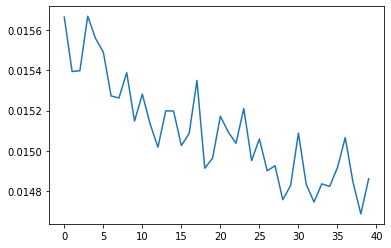

In [76]:
plt.plot(history.history['loss'][10:])

In [74]:
model.save('/content/drive/MyDrive/new_model2.h5')

In [75]:
model = tf.keras.models.load_model('/content/drive/MyDrive/new_model2.h5')

In [77]:
a = model.predict(np.reshape(x_valid_std[:100], (1,100)))
a

array([[-0.8825892]], dtype=float32)

In [78]:
x_valid_std[101]

array([-0.89952675])

In [79]:
valid_dataset =  windowed_dataset(x_valid_std, window_size = window_size, prediction_window = prediction_window
                           , batch_size = batch_size,shuffle_buffer = shuffle_buffer)

In [80]:
model.evaluate(valid_dataset)

262/262 [==============================] - 9s 20ms/step - loss: 0.1501


0.15011397004127502

In [81]:
aa = []
for i in tqdm(range(len(x_valid_std)-100)):
  a = model.predict(np.reshape(x_valid_std[i:i+100], (1,100)))

  aa.append(std_scaler.inverse_transform(a))

100%|██████████| 8371/8371 [08:53<00:00, 15.69it/s]


In [82]:
np.shape(aa)
results = np.reshape(aa, (8371,))
np.shape(results)
results[:10]

array([1826.3639, 1825.0898, 1825.3348, 1825.6129, 1825.6871, 1825.6656,
       1825.7538, 1824.399 , 1824.3291, 1823.773 ], dtype=float32)

In [83]:
x_valid[:10]

array([1825.608, 1825.698, 1825.648, 1825.568, 1826.068, 1825.768,
       1824.753, 1824.488, 1823.953, 1824.543])

In [84]:
tmp_df = pd.DataFrame()
tmp_df['x_valid'] = list(x_valid[100:])
tmp_df['predicted'] = results
tmp_df['diff'] = np.abs(tmp_df['x_valid'] - tmp_df['predicted'])
tmp_df['diff_perc'] = (tmp_df['diff'] / tmp_df['x_valid'])*100
tmp_df.head()

,x_valid,predicted,diff,diff_perc
0,1825.093,1826.363892,1.270892,0.069634
1,1825.393,1825.089844,0.303156,0.016608
2,1825.708,1825.334839,0.373161,0.020439
3,1825.718,1825.612915,0.105085,0.005756
4,1825.678,1825.687134,0.009134,0.000500


In [95]:
tmp_df.shape

(8371, 4)

In [85]:
tmp_df['diff'].mean()

8.6047242403788

In [86]:
tmp_df['diff_perc'].max()

4.737836400940864

In [46]:
tmp_df['x_valid'].mean()

1755.6862407119818

In [87]:
(tmp_df['diff'].mean() / tmp_df['x_valid'].mean())*100

0.49010603608132935

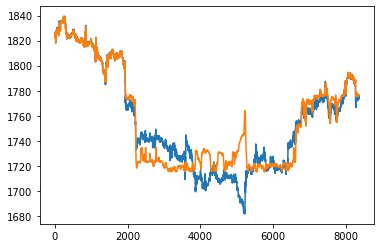

In [88]:
plt.plot(tmp_df['x_valid'])
plt.plot(tmp_df['predicted'])
#plt.axvline(x = 1800)

In [89]:
tf.keras.metrics.mean_absolute_percentage_error(np.array(tmp_df['x_valid']), np.array(tmp_df['predicted']))

<tf.Tensor: shape=(), dtype=float32, numpy=0.49853045>

## Classification

In [96]:
def generate_up_down(lst):
  state = []
  for k , v in enumerate(lst):
    if k == 0:
      prev = v
      continue
    else:
      if v > prev:
        state.append('UP')
      elif v < prev:
        state.append('Down')
      elif v == prev:
        state.append('Stable')
      prev = v

  return state


In [100]:
pred_labels = generate_up_down(tmp_df['predicted'])
valid_labels = generate_up_down(tmp_df['x_valid'])

from sklearn.metrics import accuracy_score

print('accuracy in valid prediction is:', np.round(accuracy_score(valid_labels, pred_labels)*100,2),'%')

print(pred_labels[1000:1010])
print(valid_labels[1000:1010])

accuracy in valid prediction is: 48.1 %
['Down', 'UP', 'UP', 'Down', 'UP', 'Down', 'Down', 'UP', 'Down', 'Down']
['UP', 'UP', 'Down', 'UP', 'Down', 'Down', 'UP', 'Down', 'Down', 'Down']
